# Chapter 07
- SageMaker에 내장된 k-means 알고리즘을 사용하여 모델 구축, 학습 배포를 진행해 본다.
- k-means 알고리즘 : 클러스터링 알고리즘
<img src="./images/k-means.png" alt="Neural" style="height: 200px;"/>
### 1) 세팅

In [1]:
from sagemaker import get_execution_role # 생성했던 IAM 역할 호출

role = get_execution_role()
bucket='amathon-seon-s3' # s3 이름 입력

ModuleNotFoundError: No module named 'sagemaker'

In [2]:
%%time
import pickle, gzip, numpy, urllib.request, json

# MNIST Dataset 다운로드
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1') # 바로 불러오기까지 진행

CPU times: user 938 ms, sys: 330 ms, total: 1.27 s
Wall time: 15.4 s


- Valid set : 모델을 개선하는데 사용, 성능평가
- Test set : 모델을 테스트 하는데 사용, 최종평가
<img src="./images/validation.png" alt="Neural" style="height: 150px;"/>

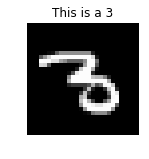

In [12]:
# 이미지를 하나 가져와서 데이터 확인
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

In [13]:
%%time
from sagemaker.amazon.common import write_numpy_to_dense_tensor
import io
import boto3

data_key = 'kmeans/data'
data_location = 's3://{}/{}'.format(bucket, data_key)
print('training data will be uploaded to: {}'.format(data_location))

# numpy.array 형식에서 k-means 학습에 효과적인 RecordIO protobuf 형식으로 변환(SageMaker 특화)
buf = io.BytesIO()
write_numpy_to_dense_tensor(buf, train_set[0], train_set[1])
buf.seek(0)

# s3에 training 데이터셋 저장
boto3.resource('s3').Bucket(bucket).Object(data_key).upload_fileobj(buf)

training data will be uploaded to: s3://amathon-seon-s3/kmeans/data
CPU times: user 7.94 s, sys: 288 ms, total: 8.23 s
Wall time: 8.87 s


### 2) 모델 훈련

In [14]:
from sagemaker import KMeans # SageMaker에 내장되어있는 kmeans 알고리즘 불러오기.

data_location = 's3://{}/kmeans/data'.format(bucket) # 위에서 저장한 training 데이터 위치
output_location = 's3://{}/kmeans_model/output'.format(bucket) # 모델이 저장될 위치

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role, # IAM 역할
                train_instance_count=2, # 모델 훈련에 사용할 인스턴스 유형과 수
                train_instance_type='ml.c4.8xlarge',
                output_path=output_location, # 훈련 모델 저장 위치
                k=10, # 생성할 클러스터의 숫자
                data_location=data_location) # Training 데이터의 위치

training data will be uploaded to: s3://amathon-seon-s3/kmeans/data
training artifacts will be uploaded to: s3://amathon-seon-s3/kmeans_model/output


### 3) 모델 배포

In [15]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=1, # 배포에 사용할 인스턴스 숫자와 타입
                                 instance_type='ml.m4.xlarge')

ValueError: Estimator is not associated with a training job